In [6]:
import tensorflow as tf
import tensorflow_datasets as tfds

dataset, info = tfds.load('malaria', split='train', with_info=True)


In [4]:
print("Num classes: " + str(info.features['label'].num_classes))
print("Class names: " + str(info.features['label'].names))

Num classes: 2
Class names: ['parasitized', 'uninfected']


Visualizing an example of Malaria dataset

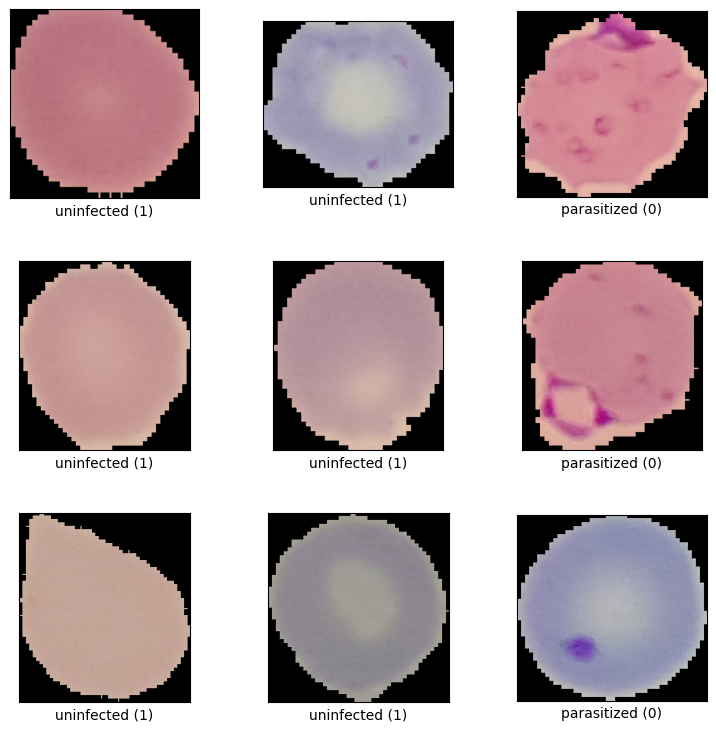

In [5]:
vis = tfds.visualization.show_examples(dataset, info)

convert our images and labels into numpy arrars for our initial analysis.

In [6]:
train_images = []
train_labels = []

for example in dataset:
    train_images.append(example['image'].numpy())
    train_labels.append(example['label'].numpy())

In [7]:
import numpy as np

train_images = np.array(train_images)
train_labels = np.array(train_labels)

C:\Users\USER\AppData\Local\Temp\ipykernel_13832\3054426191.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  train_images = np.array(train_images)


In [8]:
print("Image:")
print(train_images[0])
print("Label: " + str(train_labels[0]))

Image:
[[[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 ...

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]

 [[0 0 0]
  [0 0 0]
  [0 0 0]
  ...
  [0 0 0]
  [0 0 0]
  [0 0 0]]]
Label: 1


In [9]:
images_flattened = [x.flatten().astype('float64') for x in train_images]

In [10]:
img_lengths = []

for img in images_flattened:
    img_lengths.append(len(img))

In [11]:
img_lengths = np.array(img_lengths)

 lengths of the images identified as "uninfected" differ from the lengths of the images identifies as "parasitized"

In [12]:
uninfected_lengths = img_lengths[train_labels]
parasitized_lengths = img_lengths[train_labels == 0]

In [13]:
import scipy
import scipy.stats
scipy.stats.describe(uninfected_lengths)
scipy.stats.describe(parasitized_lengths)

DescribeResult(nobs=13779, minmax=(6600, 371280), mean=54644.67798824298, variance=271685467.8317778, skewness=2.7492421162518896, kurtosis=26.067885001336347)

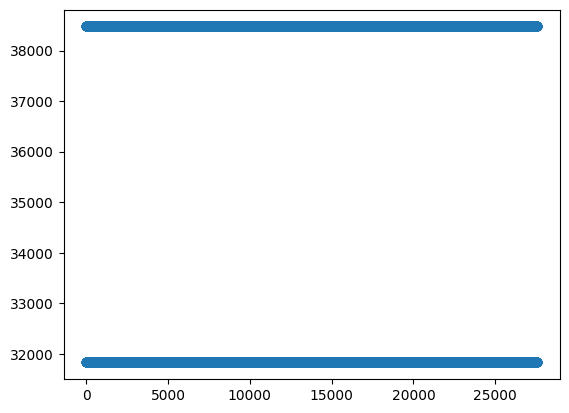

In [14]:
import matplotlib.pyplot as plt
plt.scatter(np.arange(len(uninfected_lengths)), uninfected_lengths)

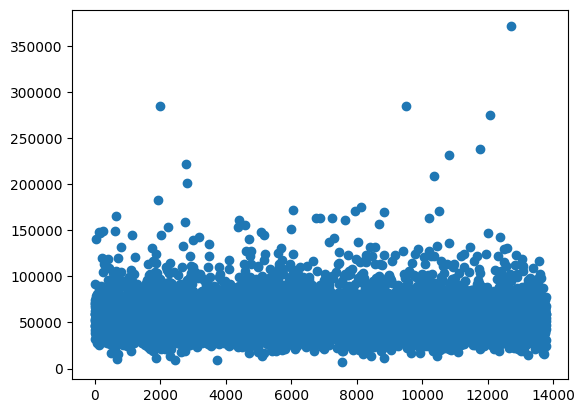

In [15]:
plt.scatter(np.arange(len(parasitized_lengths)), parasitized_lengths)

In [16]:
np.unique(uninfected_lengths)


array([31827, 38478])

In [17]:
np.unique(parasitized_lengths)

array([  6600,   9048,   9660,  10902,  11136,  11163,  13224,  14016,
        14070,  14592,  15330,  15879,  15960,  16590,  16644,  17202,
        17220,  17301,  17850,  18012,  18615,  18696,  18723,  19110,
        19272,  19380,  19434,  19497,  20064,  20145,  20172,  20586,
        20748,  20856,  20910,  21243,  21567,  21648,  21675,  21900,
        22116,  22143,  22386,  22440,  22800,  22989,  23124,  23205,
        23214,  23232,  23700,  23862,  23871,  23970,  24024,  24411,
        24600,  24735,  24816,  24843,  24852,  25122,  25500,  25608,
        25662,  25833,  26076,  26220,  26265,  26400,  26481,  26508,
        26814,  27030,  27156,  27192,  27255,  27300,  27336,  27354,
        27795,  27966,  27984,  28119,  28200,  28227,  28272,  28290,
        28560,  28776,  28938,  29028,  29046,  29100,  29325,  29568,
        29757,  29766,  29892,  29973,  30000,  30090,  30360,  30504,
        30576,  30738,  30846,  30855,  30900,  31152,  31395,  31584,
      

For the parasitized lengths, we see that images are a wide variety of lengths. For certain models, having a feature that corresponds with the label can be an issue as the model might assume that the length of an image corresponds with its classification. This will make it difficult to generalize the model as not all uninfected blood smear images are of the same size. To help prevent overfitting and to generalize our model, we will preprocess our images before inputing them.


In [7]:
BATCH_SIZE = 32
IMAGE_SIZE = [200, 200]

train_ds, val_ds, test_ds = tfds.load('malaria',
                                      split=['train[:70%]', 'train[70%:85%]', 'train[85%:]'],
                                      shuffle_files=True, as_supervised=True)

In [8]:
NUM_TRAIN_IMAGES = tf.data.experimental.cardinality(train_ds).numpy()
print("Num training images: " + str(NUM_TRAIN_IMAGES))

NUM_VAL_IMAGES = tf.data.experimental.cardinality(val_ds).numpy()
print("Num validating images: " + str(NUM_VAL_IMAGES))

NUM_TEST_IMAGES = tf.data.experimental.cardinality(test_ds).numpy()
print("Num testing images: " + str(NUM_TEST_IMAGES))

Num training images: 19291
Num validating images: 4133
Num testing images: 4134


In [20]:
for image, label in train_ds.take(1):
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())

Image shape:  (103, 103, 3)
Label:  0


Some of our images are not of size (200, 200). TensorFlow Image API has a way to resize images by either cropping big pictures or padding smaller ones.

In [11]:
def convert(image, label):
  image = tf.image.convert_image_dtype(image, tf.float32)
  return image, label

def pad(image,label):
  image,label = convert(image, label)
  image = tf.image.resize_with_crop_or_pad(image, 200, 200)
  return image,label

We can .map() to apply our padding method to all of our images and we should batch our images.

In [12]:
padded_train_ds = (
    train_ds
    .cache()
    .map(pad)
    .batch(BATCH_SIZE)
) 

padded_val_ds = (
    val_ds
    .cache()
    .map(pad)
    .batch(BATCH_SIZE)
) 

Visualizing padded images

In [28]:
image_batch, label_batch = next(iter(padded_train_ds))

def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    for n in range(20):
        ax = plt.subplot(5,4,n+1)
        plt.imshow(image_batch[n])
        if label_batch[n]:
            plt.title("uninfected")
        else:
            plt.title("parasitized")
        plt.axis("off")

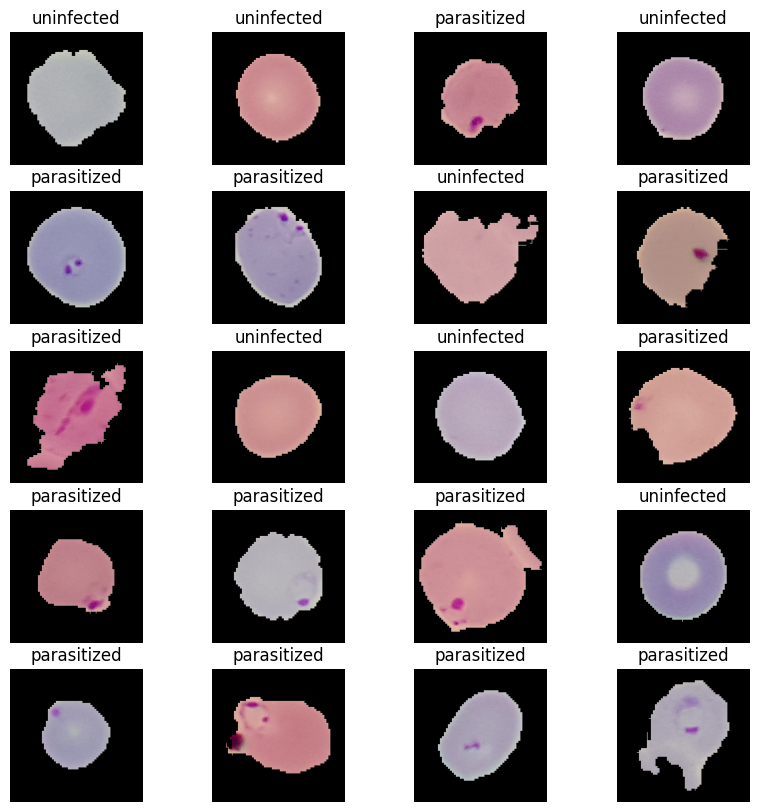

In [29]:
show_batch(image_batch.numpy(), label_batch.numpy())

Build the model
Let's build our deep CNN. We will be using the TensorFlow Keras API for implementation.

We'll create two blocks, one convolution block and one dense block so we won't have to repeat our code.

In [25]:
def conv_block(filters):
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D()
    ]
    )
    
    return block

def dense_block(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate)
    ])
    
    return block

Now we'll define our model. We want our last layer to be a dense layer with a single node. The closer the value is to 1, the higher likelihood that the image is uninfected. Values closer to 0 indice a higher probability of being parasitized.

In [26]:
def build_model():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        conv_block(64),
        
        conv_block(128),
        tf.keras.layers.Dropout(0.2),
        
        conv_block(256),
        tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),
        
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    return model

we are working on a classification problem, I will be using a binary crossentropy loss function.This data is balanced. This means that half of the images are parasitized and half the images are uninfected.

In [27]:
model = build_model()

model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=tf.keras.metrics.AUC(name='auc')
)

One of the most important hyperparameters is the learning rate. A learning rate that is too high will prevent the model from converging. Conversely, a learning rate that is too slow will cause the training process to be too long and take up unnecessary resources. We'll be using an exponential decay function to change our learning rate for each epoch.

In [27]:
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("malaria_model.h5",
                                                    save_best_only=True)

early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=5,
                                                     restore_best_weights=True)

def exponential_decay(lr0, s):
    def exponential_decay_fn(epoch):
        return lr0 * 0.1 **(epoch / s)
    return exponential_decay_fn

exponential_decay_fn = exponential_decay(0.01, 20)

lr_scheduler = tf.keras.callbacks.LearningRateScheduler(exponential_decay_fn)

In [28]:
history = model.fit(
    padded_train_ds, epochs=5,
    validation_data=padded_val_ds,
    callbacks=[checkpoint_cb, early_stopping_cb, lr_scheduler] 
)

Epoch 1/5
603/603 [==============================] - 4605s 8s/step - loss: 0.6686 - auc: 0.6497 - val_loss: 0.7054 - val_auc: 0.5231 - lr: 0.0100
Epoch 2/5
603/603 [==============================] - 5569s 9s/step - loss: 0.6415 - auc: 0.6859 - val_loss: 0.6787 - val_auc: 0.6568 - lr: 0.0089
Epoch 3/5
603/603 [==============================] - 6639s 11s/step - loss: 0.6346 - auc: 0.6940 - val_loss: 1.3115 - val_auc: 0.6883 - lr: 0.0079
Epoch 4/5
603/603 [==============================] - 9008s 15s/step - loss: 0.6297 - auc: 0.7035 - val_loss: 3.6440 - val_auc: 0.5391 - lr: 0.0071
Epoch 5/5
603/603 [==============================] - 7004s 12s/step - loss: 0.6497 - auc: 0.6403 - val_loss: 0.7056 - val_auc: 0.5637 - lr: 0.0063


In [1]:
import tensorflow as tf

# Define the path where your model is saved
model = "malaria_model.h5"

# Load the model
model = tf.keras.models.load_model(model)

print("Model loaded successfully from:", model)


Model loaded successfully from: <keras.engine.sequential.Sequential object at 0x000001696789B790>


In [2]:
model

In [3]:
history = model

In [13]:
padded_test_ds = (
     test_ds
    .cache()
    .map(pad)
    .batch(BATCH_SIZE)
) 

Evaluate results

In [14]:
model.evaluate(padded_test_ds)

130/130 [==============================] - 85s 640ms/step - loss: 0.1519 - auc: 0.9804


[0.15192697942256927, 0.9803928136825562]

In [ ]:
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 200, 200, 16)      448       
                                                                 
 conv2d_1 (Conv2D)           (None, 200, 200, 16)      2320      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 100, 100, 16)     0         
 )                                                               
                                                                 
 sequential (Sequential)     (None, 50, 50, 32)        2160      
                                                                 
 sequential_1 (Sequential)   (None, 25, 25, 64)        7392      
                                                                 
 sequential_2 (Sequential)   (None, 12, 12, 128)       27072     
                                                      